In [13]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import s3fs 
import glob 
import warnings

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [5]:
dset = open_s3fs('PC-data')
dset 

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [77]:
dx = 10 
dy = 10 

In [139]:
u = dset.vozocrtx.sel(y=slice(800,1800), x=slice(200,1400))
v = dset.vomecrty.sel(y=slice(800,1800), x=slice(200,1400))
uv = dset.vel.sel(y=slice(800,1800), x=slice(200,1400))

In [140]:
u.shape

(75, 1000, 1200)

In [141]:
# chooseing a level to look at 
level_list = [0, 7, 14, 20, 35, 50, 60]
depth_list = np.zeros(7)
for i, level in enumerate(level_list):
    depth = dset.depth[level].values
    depth_list[i] = depth
#print(depth_list)

In [142]:
# funcktion for rolling mean 
def running_mean(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1

        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

In [158]:
'A funcktion for constructing PC at a given level '
def PC_funk(level):
    warnings.filterwarnings('ignore')
    
    dx = 10 
    dy = 10 
    jmax, imax = uv[0].shape #fetches the max value in j and i direction 
    i_list = np.arange(0,imax,dx)
    j_list = np.arange(0,jmax,dy)
    
    # Making the covmatrix and finding the eigenvalues and eigenvectors
    # list of all the points for the PC-crosses
    'Dont remember how I got to this number, so dont know how to change the number of points in each PC'
    PC11 = []
    PC12 = []
    PC21 = []
    PC22 = []
    y = []
    x = []
    indx = 0
    
    # to get the loop to run faster
    uvy = np.array(uv.y.values)
    uvx = np.array(uv.x.values)
    
    # fetching the varaibel at the given level 
    uvar_depth = np.array(u[level,:,:].values)
    vvar_depth = np.array(v[level,:,:].values)
    uv_depth = np.array(uv[level,:,:].values)
    
    for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
            [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                values, vectors = np.linalg.eig(covm)
                PC11.append(vectors[0,0]*np.sqrt(values[0]))
                PC12.append(vectors[1,0]*np.sqrt(values[0]))
                PC21.append(vectors[0,1]*np.sqrt(values[1]))
                PC22.append(vectors[1,1]*np.sqrt(values[1]))
                y.append(uvy[j])
                x.append(uvx[i])
                indx = indx + 1
                
    # converting to np.arrays
    PC11 = np.array(PC11,dtype=float)
    PC12 = np.array(PC12,dtype=float)
    PC21 = np.array(PC21,dtype=float)
    PC22 = np.array(PC22,dtype=float)
    y = np.array(y,dtype=float)
    x = np.array(x,dtype=float)
    
    # smoothening the data
    PC11 = running_mean(PC11, 10)
    PC12 = running_mean(PC12, 10)
    PC21 = running_mean(PC21, 10)
    PC22 = running_mean(PC22, 10)
    
    return PC11, PC12, PC21, PC22, x, y 

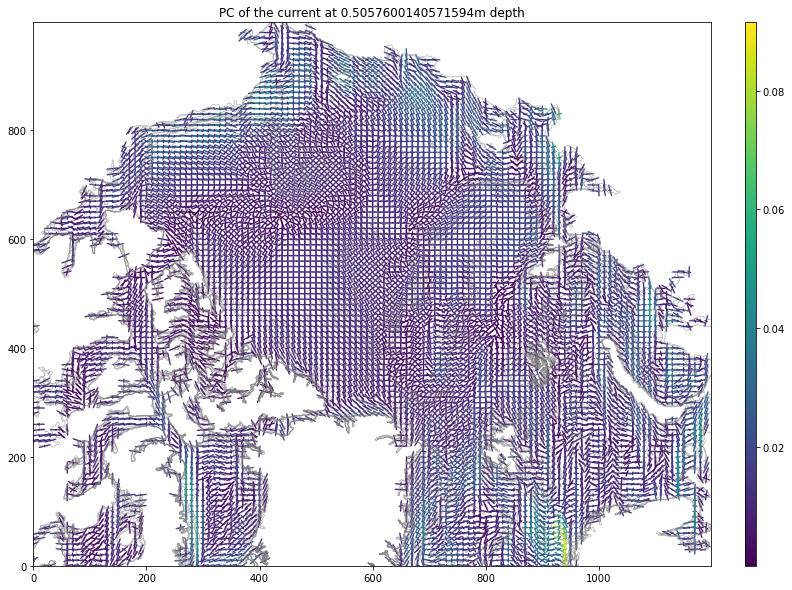

In [159]:
# Plot level 1
n = 0
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy[800:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
c = ax.quiver( x, y, PC11_s/styrke_midlet, PC12_s/styrke_midlet, 
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver(x, y, -PC11_s/styrke_midlet, -PC12_s/styrke_midlet,
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, PC21_s/styrke_midlet, PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, -PC21_s/styrke_midlet, -PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
#ax.set_xlim(200,1400)
#ax.set_ylim(800,1800)

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)


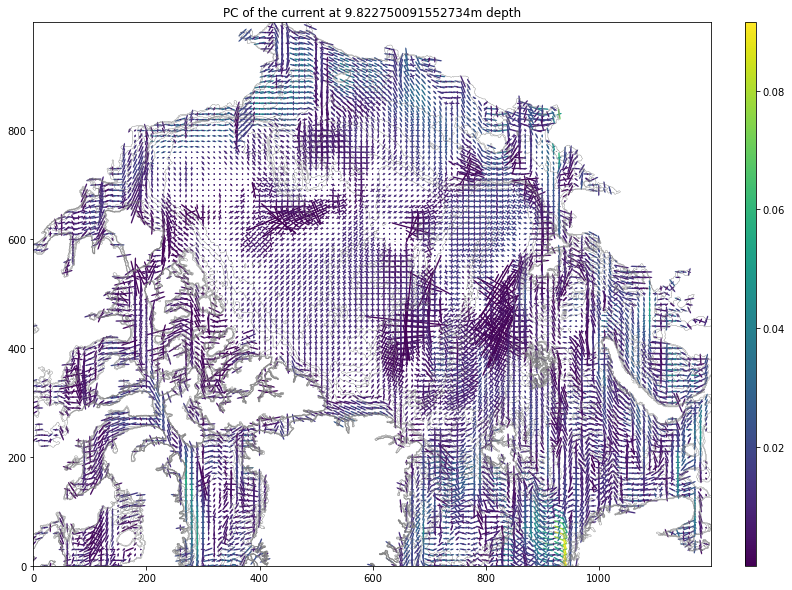

In [160]:
# Plot level 2
n = 1
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy[800:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
c = ax.quiver( x, y, PC11_s/styrke_midlet, PC12_s/styrke_midlet, 
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver(x, y, -PC11_s/styrke_midlet, -PC12_s/styrke_midlet,
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, PC21_s/styrke_midlet, PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, -PC21_s/styrke_midlet, -PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
#ax.set_xlim(200,1400)
#ax.set_ylim(800,1800)

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)


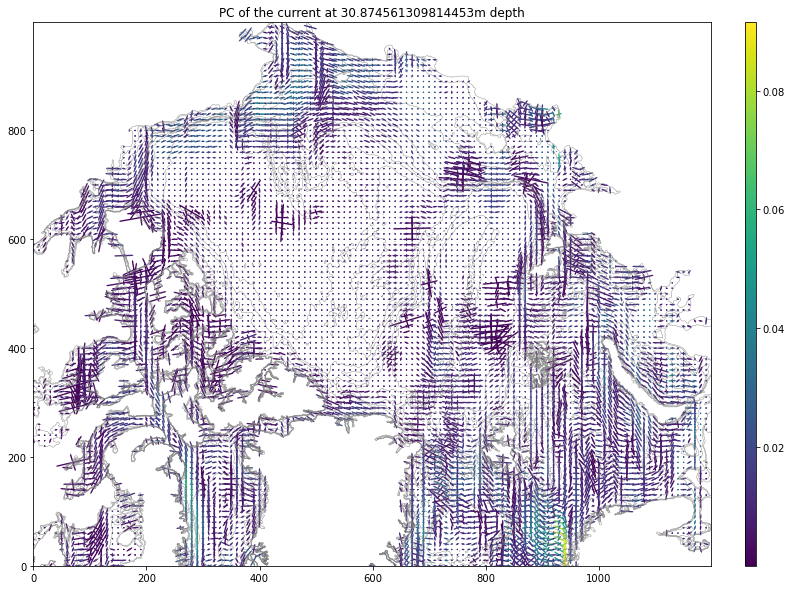

In [161]:
# Plot level 3
n = 2
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy[800:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
c = ax.quiver( x, y, PC11_s/styrke_midlet, PC12_s/styrke_midlet, 
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver(x, y, -PC11_s/styrke_midlet, -PC12_s/styrke_midlet,
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, PC21_s/styrke_midlet, PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, -PC21_s/styrke_midlet, -PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
#ax.set_xlim(200,1400)
#ax.set_ylim(800,1800)

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)


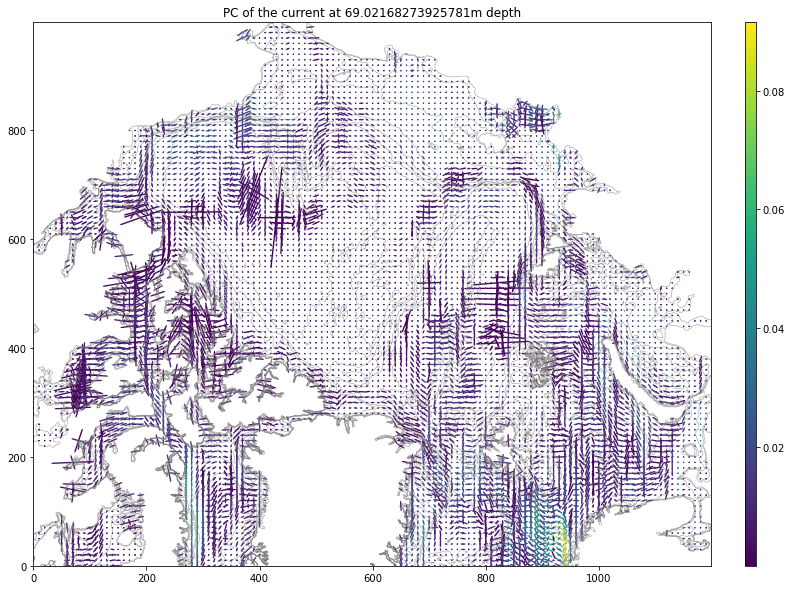

In [162]:
# Plot level 4
n = 3
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy[800:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
c = ax.quiver( x, y, PC11_s/styrke_midlet, PC12_s/styrke_midlet, 
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver(x, y, -PC11_s/styrke_midlet, -PC12_s/styrke_midlet,
    #color='r',
    styrke_1,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, PC21_s/styrke_midlet, PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
ax.quiver( x, y, -PC21_s/styrke_midlet, -PC22_s/styrke_midlet,
    #color='b',
    styrke_2,
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=100)
#ax.set_xlim(200,1400)
#ax.set_ylim(800,1800)

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)
